In [1]:
from __future__ import division, print_function, absolute_import

In [2]:
import tensorflow as tf

import time

import numpy as np

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

# Generating Reber strings

### Defining the grammar
<img src='misc/reber.jpg'>

In [4]:
default_reber_grammar=[
    [("B",1)],  #(state 0) =B=> (state 1)
    [("T", 2),("P", 3)],  # (state 1) =T=> (state 2) or =P=> (state 3)
    [("X", 5), ("S", 2)], # (state 2) =X=> (state 5) or =S=> (state 2)
    [("T", 3), ("V", 4)], # (state 3) =T=> (state 3) or =V=> (state 4)
    [("V", 6), ("P", 5)], # (state 4) =V=> (state 6) or =P=> (state 5)
    [("X",3), ("S", 6)],  # (state 5) =X=> (state 3) or =S=> (state 6)
    [("E", None)]         # (state 6) =E=> <EOS>
    
]

### Embedded Reber Grammar
<img src="misc/embedded.gif">

In [5]:
embedded_reber_grammar=[
    [("B",1)],  #(state 0) =B=> (state 1)
    [("T", 2),("P", 3)],  # (state 1) =T=> (state 2) or =P=> (state 3)
    [(default_reber_grammar,4)], # (state 2) =REBER=> (state 4)
    [(default_reber_grammar,5)], # (state 3) =REBER=> (state 5)
    [("P", 6)], # (state 4) =P=> (state 6)
    [("T",6)],  # (state 5) =T=> (state 3)
    [("E", None)]         # (state 6) =E=> <EOS>
    
]

### Generating data

In [6]:
def generate_valid_string(grammar):
    state = 0
    output = []
    while state is not None:
        char, state = grammar[state][np.random.randint(len(grammar[state]))]
        if isinstance(char, list):  # embedded reber
            char = generate_valid_string(char)
        output.append(char)
    return "".join(output)

In [7]:
def generate_corrupted_string(grammar, chars='BTSXPVE'):
    '''Substitute one character to violate the grammar'''
    good_string = generate_valid_string(grammar)
    idx = np.random.randint(len(good_string))
    good_char = good_string[idx]
    bad_char = np.random.choice(sorted(set(chars)-set(good_char)))
    return good_string[:idx]+bad_char+good_string[idx+1:]

In [8]:
chars='BTSXPVE'
chars_dict = {a:i for i,a in enumerate(chars)}
chars_dict

{'B': 0, 'E': 6, 'P': 4, 'S': 2, 'T': 1, 'V': 5, 'X': 3}

In [9]:
def str2onehot(string, num_steps=12, chars_dict=chars_dict):
    res = np.zeros((num_steps, len(chars_dict)))
    for i in range(min(len(string), num_steps)):
        c = string[i]
        res[i][chars_dict[c]] = 1
    return res

In [10]:
# def generate_data(size):
#     good_strings = [generate_valid_string(embedded_reber_grammar)
#                     for _ in range(size // 2)]
#     bad_strings = [generate_corrupted_string(embedded_reber_grammar)
#                    for _ in range(size - size // 2)]
#     all_strings = good_strings + bad_strings
#     n_steps = max([len(string) for string in all_strings])
#     X = np.array([str2onehot(string, n_steps)
#                   for string in all_strings])
#     seq_length = np.array([len(string) for string in all_strings])
#     y = np.array([[1] for _ in range(len(good_strings))] +
#                  [[0] for _ in range(len(bad_strings))])
#     rnd_idx = np.random.permutation(size)
#     return X[rnd_idx], seq_length[rnd_idx], y[rnd_idx]

In [11]:
def generate_data(data_size=10000, grammar=embedded_reber_grammar, num_steps=None):
    good = [generate_valid_string(grammar) for _ in range(data_size//2)]
    bad = [generate_corrupted_string(grammar) for _ in range(data_size//2)]
    all_strings = good+bad
    if num_steps is None:
        num_steps = max([len(s) for s in all_strings])
    X = np.array([str2onehot(s) for s in all_strings])
    l = np.array([len(s) for s in all_strings])
    y = np.concatenate((np.ones(len(good)), np.zeros((len(bad))))).reshape(-1, 1)
    idx = np.random.permutation(data_size)
    return X[idx], l[idx], y[idx]

In [12]:
np.random.seed(42)
X_train, seq_lens_train, y_train = generate_data(10000)
X_val, seq_lens_val, y_val = generate_data(5000)
X_train.shape, X_val.shape

((10000, 12, 7), (5000, 12, 7))

## Define the graph

In [13]:
num_inputs = len(chars)
num_neurons = 32
num_outputs = 1  # reber or not

In [14]:
graph = tf.Graph()

with graph.as_default():
    X = tf.placeholder(tf.float32, [None, None, num_inputs])
    seq_lens = tf.placeholder(tf.int32, [None])
    y = tf.placeholder(tf.float32, [None, num_outputs])
    
    with tf.name_scope("Model"):
        gru_cell = tf.contrib.rnn.GRUCell(num_neurons)
        outputs, states = tf.nn.dynamic_rnn(gru_cell, X, seq_lens, dtype=tf.float32)
    
    with tf.name_scope("logits"):
        logits = tf.layers.dense(states, num_outputs)
    
    with tf.name_scope("optimization"):
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits))

        optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    
    with tf.name_scope("Evaluation"):
        predictions = tf.cast(tf.greater(logits, 0.), tf.float32, name="predicitons")
        correct = tf.equal(predictions, y)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [15]:
def run_session(graph, num_epochs=1000, p_every=1, batch_size=50):
    start = time.time()
    with tf.Session(graph=graph) as sess:
        with tf.device('/gpu'):
            init.run()
            train_accuracies = dict()
            val_accuracies = dict()
            losses = dict()
            avg_loss = 0
            X_batches = np.array_split(X_train, len(X_train)//batch_size)
            l_batches = np.array_split(seq_lens_train, len(seq_lens_train)//batch_size)
            y_batches = np.array_split(y_train, len(y_train)//batch_size)
            avg_loss = 0
            for e in range(num_epochs+1):
                for X_batch,l_batch,y_batch in zip(X_batches, l_batches, y_batches):
                    feed_dict = {X:X_batch, seq_lens:l_batch, y: y_batch.reshape(-1, 1)}
                    _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
                avg_loss += loss_val
                if e%p_every == 0:
                    train_accuracy = accuracy.eval(
                        feed_dict = {X:X_train, seq_lens:seq_lens_train, y: y_train.reshape(-1, 1)})

                    val_accuracy = accuracy.eval(
                                             feed_dict={X:X_val,
                                                        seq_lens:seq_lens_val,
                                                        y:y_val.reshape(-1, 1)})

                    losses[e] = avg_loss/p_every if e>0 else avg_loss
                    train_accuracies[e] = train_accuracy
                    val_accuracies[e] = val_accuracy
                    print("Epoch {0}:\nCross_entropy: {1}\nTrain accuracy: {2}\nval accuracy: {3}".format(
                    e, avg_loss/10 if e>0 else avg_loss, train_accuracy, val_accuracy))
                    print("~"*40)
                    
                    avg_loss = 0
                    
            print("Took: ", time.time()-start)
            saver.save(sess,('./reber'))
        

        fig, ax1 = plt.subplots(figsize=(12,7))
        xticks = sorted(losses.keys())
        data1_valid = [train_accuracies[i] for i in xticks]
        data1_val = [val_accuracies[i] for i in xticks]
        data2 = [losses[i] for i in xticks]

        color = 'tab:blue'
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy', color=color)
        ax1.plot(xticks, data1_valid, color=color)
        ax1.plot(xticks, data1_val, color='tab:green')
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:red'
        ax2.set_ylabel('Cross-entropy loss', color=color)
        ax2.plot(xticks, data2, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        ax1.legend(['Train. accuracy', 'val. accuracy'], loc='lower center')
        ax2.legend(['Train Cross-entropy loss'], loc='upper left')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped

Epoch 0:
Cross_entropy: 0.6932171583175659
Train accuracy: 0.5194000005722046
val accuracy: 0.5188000202178955
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1:
Cross_entropy: 0.05928940176963806
Train accuracy: 0.613099992275238
val accuracy: 0.6194000244140625
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2:
Cross_entropy: 0.05323023200035095
Train accuracy: 0.6514000296592712
val accuracy: 0.6538000106811523
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3:
Cross_entropy: 0.0502572238445282
Train accuracy: 0.7081000208854675
val accuracy: 0.7139999866485596
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4:
Cross_entropy: 0.048788121342658995
Train accuracy: 0.7222999930381775
val accuracy: 0.7269999980926514
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5:
Cross_entropy: 0.04379260838031769
Train accuracy: 0.7710000276565552
val accuracy: 0.7738000154495239
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 6:
Cross_entropy: 0.042197981476783754
Train accuracy: 0.7851999998092651
val 

Epoch 54:
Cross_entropy: 0.012182982265949249
Train accuracy: 0.9549999833106995
val accuracy: 0.954800009727478
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 55:
Cross_entropy: 0.012387336790561676
Train accuracy: 0.9553999900817871
val accuracy: 0.9549999833106995
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 56:
Cross_entropy: 0.012707984447479248
Train accuracy: 0.9556000232696533
val accuracy: 0.9556000232696533
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 57:
Cross_entropy: 0.012734851241111756
Train accuracy: 0.9557999968528748
val accuracy: 0.9559999704360962
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 58:
Cross_entropy: 0.01265355497598648
Train accuracy: 0.955299973487854
val accuracy: 0.9557999968528748
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 59:
Cross_entropy: 0.01253746747970581
Train accuracy: 0.9556999802589417
val accuracy: 0.9553999900817871
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 60:
Cross_entropy: 0.012244926393032074
Train accuracy: 0.9555000066

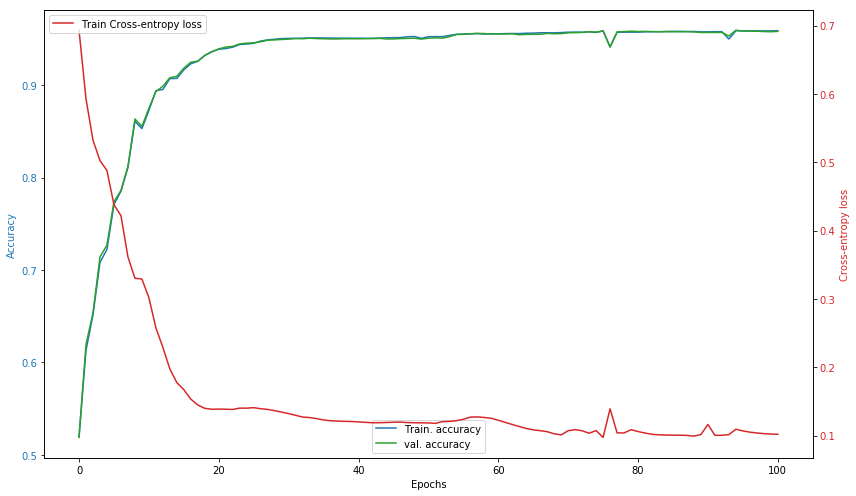

In [16]:
run_session(graph, num_epochs=100, batch_size=75)